In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
data = pd.read_excel('DataSet_JPCLett.xlsx')

In [3]:
data.shape

(1203, 16)

In [4]:
data.head()

,ID No.,Nickname,Ref. No,PCE_max(%),PCE_ave(%),Voc (V),Jsc (mA cm^2),FF,Mw (kg mol^-1),Mn (kg mol^-1),PDI (=Mw/Mn),Monomer (g mol^-1),HOMO (eV),LUMO (eV),bandgap(eV),SMILES
0,1,PBTTT-C14,S1,2.34,2.34,0.53,9.37,0.48,46.2,22,2.1,724,5.10,3.10,1.88,CC1=CC(CCCCCCCCCCCCCC)=C(C2=CC3=C(S2)C=C(C4=C(...
1,2,PCDTBT,S2,3.60,3.60,0.89,6.92,0.63,73.0,37,1.97,731,5.50,3.60,1.88,CC1=CC(N(C(CCCCCCCC)CCCCCCCC)C2=C3C=CC(C4=CC=C...
2,3,PCPDTBT,S3,5.12,5.12,0.61,15.73,0.53,47.6,26.6,1.79,564,5.30,3.55,1.43,CC1=CC(C(CC(CCCC)CC)(CC(CCCC)CC)C2=C3SC(C4=CC=...
3,4,PffBT4T-2OD,S4,10.50,10.20,0.77,18.40,0.74,93.7,47.5,1.97,1089,5.34,3.69,1.65,CC1=C(CC(CCCCCCCC)CCCCCCCCCC)C=C(C2=C(F)C(F)=C...
4,5,PffBT4T-2OD,S4,10.40,10.00,0.77,18.20,0.74,52.9,28.2,1.88,1089,5.20,3.57,1.63,CC1=C(CC(CCCCCCCC)CCCCCCCCCC)C=C(C2=CC=C(C3=CC...


In [5]:
data.describe()

,ID No.,PCE_max(%),PCE_ave(%),Voc (V),Jsc (mA cm^2),FF,Mw (kg mol^-1),Monomer (g mol^-1),HOMO (eV),LUMO (eV),bandgap(eV)
count,1203.000000,1203.000000,1203.000000,1203.000000,1203.000000,1203.000000,1203.000000,1203.000000,1203.000000,1203.000000,1203.000000
mean,602.000000,4.281588,4.220274,0.784997,9.236184,0.553442,89.966667,1125.375727,5.333392,3.507963,1.715852
std,347.420495,2.380189,2.342145,0.135218,4.064283,0.110888,139.374934,324.376769,0.220354,0.301048,0.205300
min,1.000000,0.010000,0.010000,0.200000,0.110000,0.250000,3.900000,196.000000,4.240000,2.300000,1.000000
25%,301.500000,2.415000,2.385000,0.700000,6.325000,0.480000,28.100000,887.500000,5.200000,3.340000,1.590000
50%,602.000000,4.230000,4.200000,0.800000,9.530000,0.570000,54.800000,1122.000000,5.340000,3.550000,1.710000
75%,902.500000,6.100000,5.975000,0.880000,12.100000,0.640000,99.450000,1321.000000,5.470000,3.700000,1.830000
max,1203.000000,10.700000,10.500000,1.090000,23.500000,0.767000,2535.000000,3144.000000,6.180000,4.900000,2.400000


In [6]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

In [7]:
#prepressing data
x_data = np.array(data.loc[:,'SMILES'])
print(x_data.shape, type(x_data))

(1203,) <class 'numpy.ndarray'>


In [8]:
polymers= []
for smile in x_data:
    m = Chem.MolFromSmiles(smile)
    polymers.append(m)
    
print(type(polymers), len(polymers))

<class 'list'> 1203


## y data processing

In [9]:
#y_data processing, from the average PCE values
y_data = np.array(data.loc[:,'PCE_ave(%)'])
y_data_round = np.around(y_data, decimals=2)
print(type(y_data_round), y_data_round.shape)

<class 'numpy.ndarray'> (1203,)


### Generate fingerprints: Morgan fingerprint with radius 5
### SVM and RF Modelling

[[1.         0.63150138]
 [0.63150138 1.        ]]


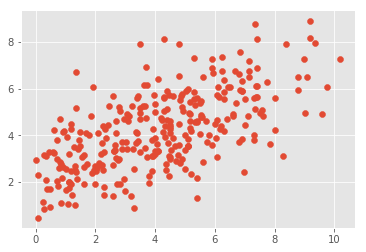

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

#Generate polymer fingerprints
fps = [AllChem.GetMorganFingerprintAsBitVect(p, 5) for p in polymers]
    
np_fps = []
for fp in fps:
    arr = np.zeros((1,))  # create a num array to accept the data
    DataStructs.ConvertToNumpyArray(fp, arr)
    np_fps.append(arr)    # this will change numpy array to list 
    
x_data = np.array(np_fps) # change list to np array

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data_round)
   
# search for the best C values
range_max = 60
efficiency = []
C_range = list(range(1, range_max, 10))

for i in C_range:
    model_svm = SVR(C=i, gamma=0.001)
    model_svm.fit(x_train, y_train)
    test_svm = model_svm.predict(x_test)
    result = np.corrcoef(y_test, test_svm)
    efficiency.append(result[0,1])

eff_np = np.array(efficiency)
max_arg = np.argmax(eff_np) 
best_C = C_range[max_arg]
model_svm = SVR(C=best_C, gamma=0.001)
model_svm.fit(x_train, y_train)
test_svm = model_svm.predict(x_test)
 
plt.scatter(y_test, test_svm)    
print(np.corrcoef(y_test, test_svm))

# Random Forrest Regression

array([[1.        , 0.64944292],
       [0.64944292, 1.        ]])

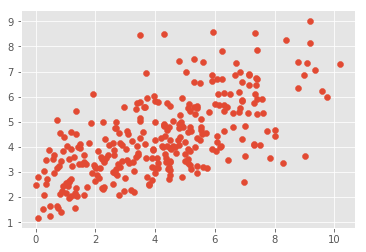

In [11]:
from sklearn.ensemble import RandomForestRegressor

model_RF = RandomForestRegressor(n_estimators=500)
model_RF.fit(x_train, y_train)
test_RF = model_RF.predict(x_test)

plt.scatter(y_test, test_RF)
np.corrcoef(y_test, test_RF)

# Average the predictive values from the two models

In [12]:
Result_two = test_svm + test_RF
Result_two = Result_two/2

array([[1.        , 0.65666898],
       [0.65666898, 1.        ]])

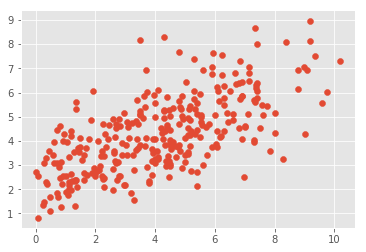

In [13]:
plt.scatter(y_test, Result_two)
np.corrcoef(y_test, Result_two)